# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [10]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
plt.style.use("seaborn-v0_8")
%matplotlib inline
# Seaborn is deprecated with matplotlib, I kept getting the error: FileNotFoundError: [Errno 2] No such file or directory: 'seaborn' when running plt.style.use('seaborn')
# StatckOverflow suggested using seaborn-v0_8 instead and it works
# https://stackoverflow.com/questions/74716259/the-seaborn-styles-shipped-by-matplotlib-are-deprecated-since-3-6

/Users/sidman/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/sidman/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

First, we run: `wget -r -N -c -np https://physionet.org/files/wearable-exam-stress/1.0.0/` in terminal to download the data.

- -r makes it recursively download all subdirectories
- -N makes it only download the newest version
- -c makes it resume downloading partially downloaded files

Now, the data is in our repo with the file path: `4-it-s-about-time-AvantikaSharma3357/physionet.org/files/wearable-exam-stress/1.0.0/data`


- StudentGrades.txt contains the grades for each student
- In the data folder, we have the data of 10 subjects-- S1-S10. For each subject we have physiological data for: Midterm 1, Midterm 2 & Final.

Each of the exam folders contain the following items and from info.txt we know that: 
- TEMP.csv contains Data from temperature sensor expressed degrees on the Celsius (°C) scale.
- BVP.csv contains Data from photoplethysmograph.
- EDA.csv contains Data from the electrodermal activity sensor expressed as microsiemens (μS).
- HR.csv contains the Average heart rate extracted from the BVP signal.
    - The first row is the initial time of the session expressed as unix timestamp in UTC. 
    - The second row is the sample rate expressed in Hz.
- IBI.csv contains the Time between individuals heart beats extracted from the BVP signal. 
    - The first column is the time (respect to the initial time) of the detected inter-beat interval expressed in seconds (s). 
    - The second column is the duration in seconds (s) of the detected inter-beat interval (i.e., the distance in seconds from the previous beat). 
- ACC.csv contains Data from 3-axis accelerometer sensor with units 1/64g and data from the x, y & z axes in the first, second and third columns respectively.
- index.html      
- info.txt        
- tags.csv


In [11]:
"""
According to the README and docstring for question 1, we need to get:
Objectives:
    - timestamp: First get the initial UTC and then use sample rate to get the timestamp of each following point
    - heart_rate: get from HR.csv
    - eda: get from EDA.csv
    - subject_id: S1-S10
    - session: Midterm 1, 2 or Final
"""
# First lets do some data exploration, in particular I want to know if EDA.csv has ~4x entries as HR.csv

import pandas as pd

eda_df = pd.read_csv('data/raw/S1/midterm_1/EDA.csv')
hr_df = pd.read_csv('data/raw/S1/midterm_1/HR.csv')

print("EDA: ", eda_df.describe())
print('\n\n')
print("HR: ", hr_df.describe())

EDA:         1539435366.000000
count       44713.000000
mean            0.325991
std             0.520389
min             0.000000
25%             0.024347
50%             0.161724
75%             0.215277
max             4.000000



HR:         1539435376.000000
count       11170.000000
mean          103.104605
std            26.321332
min             1.000000
25%            83.472500
50%            97.550000
75%           115.915000
max           194.470000


We can see that EDA does have ~4x entries as HR.

In [12]:
import os
import pandas as pd
import numpy as np

def load_data(data_dir='data/raw'):
    """Load and organize the physiological data from the dataset.

    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    all_data = []

    for root, dirs, files in os.walk(data_dir):
        if 'EDA.csv' in files and 'HR.csv' in files and 'TEMP.csv' in files:
            subject_id = root.split(os.sep)[-3]  # e.g., 'S1'
            session_name = root.split(os.sep)[-1]  # e.g., 'midterm_1'

            # Load EDA
            eda_path = os.path.join(root, 'EDA.csv')
            eda_raw = pd.read_csv(eda_path, header=None)
            eda_init_time = float(eda_raw.iloc[0, 0])
            eda_sample_rate = float(eda_raw.iloc[1, 0])
            eda_values = eda_raw.iloc[2:].reset_index(drop=True)
            eda_values.columns = ['eda']
            eda_values['timestamp'] = eda_init_time + np.arange(len(eda_values)) / eda_sample_rate

            # Load TEMP
            temp_path = os.path.join(root, 'TEMP.csv')
            temp_raw = pd.read_csv(temp_path, header=None)
            temp_init_time = float(temp_raw.iloc[0, 0])
            temp_sample_rate = float(temp_raw.iloc[1, 0])
            temp_values = temp_raw.iloc[2:].reset_index(drop=True)
            temp_values.columns = ['temperature']
            temp_values['timestamp'] = temp_init_time + np.arange(len(temp_values)) / temp_sample_rate

            # Load HR
            hr_path = os.path.join(root, 'HR.csv')
            hr_raw = pd.read_csv(hr_path, header=None)
            hr_init_time = float(hr_raw.iloc[0, 0])
            hr_sample_rate = float(hr_raw.iloc[1, 0])
            hr_values = hr_raw.iloc[2:].reset_index(drop=True)
            hr_values.columns = ['heart_rate']
            hr_values['timestamp'] = hr_init_time + np.arange(len(hr_values)) / hr_sample_rate

            # Merge based on nearest timestamp (eda → hr → temp)
            merged = pd.merge_asof(
                eda_values.sort_values('timestamp'),
                hr_values.sort_values('timestamp'),
                on='timestamp', direction='nearest', tolerance=1
            )
            merged = pd.merge_asof(
                merged.sort_values('timestamp'),
                temp_values.sort_values('timestamp'),
                on='timestamp', direction='nearest', tolerance=1
            )

            # Add metadata
            merged['subject_id'] = subject_id
            merged['session'] = session_name

            all_data.append(merged)

    final_df = pd.concat(all_data, ignore_index=True)
    return final_df

In [13]:
df = load_data()
print("Number of unique subject ids: ", df['subject_id'].nunique())
print("Number of unique sessions: ", df['session'].nunique())
unique_sessions_per_subject = df.groupby('subject_id')['session'].nunique()
print(unique_sessions_per_subject)

print("Missing Value Summary:")
print(df.isnull().sum())
print(df.count())

Number of unique subject ids:  1
Number of unique sessions:  3
subject_id
raw    3
Name: session, dtype: int64
Missing Value Summary:
eda               0
timestamp         0
heart_rate     1080
temperature      88
subject_id        0
session           0
dtype: int64
eda            1773120
timestamp      1773120
heart_rate     1772040
temperature    1773032
subject_id     1773120
session        1773120
dtype: int64


At most, we have 1168 rows containing missing values which is about 0.06% of the data. According to the readme since it's less than 1% we can simply fill/drop these values during preprocessing.

In [14]:
print("\n\nInfo: ", df.info())
print("\n\nDescription: ", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773120 entries, 0 to 1773119
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   eda          float64
 1   timestamp    float64
 2   heart_rate   float64
 3   temperature  float64
 4   subject_id   object 
 5   session      object 
dtypes: float64(4), object(2)
memory usage: 81.2+ MB


Info:  None


Description:                  eda     timestamp    heart_rate   temperature
count  1.773120e+06  1.773120e+06  1.772040e+06  1.773032e+06
mean   2.600844e-01  1.542224e+09  1.049464e+02  2.724967e+01
std    3.980789e-01  1.899976e+06  2.610244e+01  4.639360e+00
min    0.000000e+00  1.539435e+09  4.900000e+01  1.251000e+01
25%    1.025100e-02  1.539446e+09  8.357000e+01  2.291000e+01
50%    1.219930e-01  1.541870e+09  1.020200e+02  2.761000e+01
75%    3.513090e-01  1.544037e+09  1.204000e+02  3.143000e+01
max    7.412322e+00  1.544053e+09  2.061200e+02  3.607000e+01


In [15]:
df.head()

,eda,timestamp,heart_rate,temperature,subject_id,session
0,0.000000,1.541859e+09,NaN,22.17,raw,midterm_2
1,0.002562,1.541859e+09,NaN,22.17,raw,midterm_2
2,0.021776,1.541859e+09,NaN,22.17,raw,midterm_2
3,0.021776,1.541859e+09,NaN,22.17,raw,midterm_2
4,0.019214,1.541859e+09,NaN,22.17,raw,midterm_2


In [16]:
print("Timestamp Range: ")
print("Min:", df['timestamp'].min())
print("Max:", df['timestamp'].max())
print("Is sorted:", df['timestamp'].is_monotonic_increasing or df['timestamp'].is_monotonic_decreasing)

Timestamp Range: 
Min: 1539435321.0
Max: 1544053154.75
Is sorted: False


Let's sort it

In [17]:
df = df.sort_values(by='timestamp', ascending=True)
print("Timestamp Range: ")
print("Min:", df['timestamp'].min())
print("Max:", df['timestamp'].max())
print("Is sorted:", df['timestamp'].is_monotonic_increasing or df['timestamp'].is_monotonic_decreasing)

Timestamp Range: 
Min: 1539435321.0
Max: 1544053154.75
Is sorted: True


In [18]:
print("Heart Rate:")
print(df['heart_rate'].describe())

print("\nEDA:")
print(df['eda'].describe())

print("\nTemperature:")
print(df['temperature'].describe())

Heart Rate:
count    1.772040e+06
mean     1.049464e+02
std      2.610244e+01
min      4.900000e+01
25%      8.357000e+01
50%      1.020200e+02
75%      1.204000e+02
max      2.061200e+02
Name: heart_rate, dtype: float64

EDA:
count    1.773120e+06
mean     2.600844e-01
std      3.980789e-01
min      0.000000e+00
25%      1.025100e-02
50%      1.219930e-01
75%      3.513090e-01
max      7.412322e+00
Name: eda, dtype: float64

Temperature:
count    1.773032e+06
mean     2.724967e+01
std      4.639360e+00
min      1.251000e+01
25%      2.291000e+01
50%      2.761000e+01
75%      3.143000e+01
max      3.607000e+01
Name: temperature, dtype: float64


## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [19]:
df.head()

,eda,timestamp,heart_rate,temperature,subject_id,session
109062,0.000000,1.539435e+09,NaN,22.23,raw,midterm_1
109063,0.002562,1.539435e+09,NaN,22.23,raw,midterm_1
109064,0.021779,1.539435e+09,NaN,22.23,raw,midterm_1
109065,0.021779,1.539435e+09,NaN,22.23,raw,midterm_1
109066,0.019217,1.539435e+09,NaN,22.23,raw,midterm_1


In [20]:
import scipy
from scipy.stats import zscore

def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    # Added a try-except block just in case
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        print(f"An error occurred while creating the directory: {e}")
    
    # Your code here
    # Start by grouping the data by sessions, subject_id and sorting it ascendingly according to timestamp
    data_sorted = data.groupby(['session', 'subject_id']).apply(lambda x: x.sort_values('timestamp')).reset_index(drop=True)

    # 1. Handle missing values
    # Handle missing values by forward filling
    data_sorted[['eda', 'heart_rate', 'temperature']] = data_sorted.groupby(['session', 'subject_id'])[['eda', 'heart_rate', 'temperature']].ffill()
    
    # 2. Resample to regular intervals
    # Even though the datacards say it's in the right format, we'll make sure in preprocessing
    data_sorted['timestamp'] = pd.to_datetime(data_sorted['timestamp'], unit='s')
    data_sorted.set_index('timestamp', inplace=True)
    
    resampled = []
    for (session, subject_id), group in data_sorted.groupby(['session', 'subject_id']):
        numeric_cols = ['eda', 'heart_rate', 'temperature']
        resampled_group = group[numeric_cols].resample('1S').mean()
        resampled_group['subject_id'] = subject_id
        resampled_group['session'] = session
        resampled.append(resampled_group)
    data_resampled = pd.concat(resampled).reset_index()

    # 3. Remove outliers (z-score > 3)
    for col in ['eda', 'heart_rate', 'temperature']:
        z_scores = zscore(data_resampled[col].dropna())
        mask = np.abs(z_scores) > 3
        data_resampled.loc[data_resampled[col].dropna().index[mask], col] = np.nan

    # 4. Save processed data to CSV files
    for (session, subject_id), group in data_resampled.groupby(['session', 'subject_id']):
        filename = f"{subject_id}_{session}.csv"
        save_path = os.path.join(output_dir, filename)
        group.to_csv(save_path, index=False)

    return data_resampled

In [21]:
preprocessed_df = preprocess_data(df)

/var/folders/lf/vy54s7jd6c99hcpkx8rkbxmr0000gn/T/ipykernel_83607/71871771.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_sorted = data.groupby(['session', 'subject_id']).apply(lambda x: x.sort_values('timestamp')).reset_index(drop=True)
/var/folders/lf/vy54s7jd6c99hcpkx8rkbxmr0000gn/T/ipykernel_83607/71871771.py:42: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_group = group[numeric_cols].resample('1S').mean()
/var/folders/lf/vy54s7jd6c99hcpkx8rkbxmr0000gn/T/ipykernel_83607/71871771.py:42: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_group = group[numeric_col

## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [22]:
import matplotlib.pyplot as plt

def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Create figure with subplots
    # 2. Plot each physiological signal
    # 3. Add labels and titles
    # 4. Save plot to file
    
    filtered = data[(data['subject_id'] == subject_id) & (data['session'] == session)]
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    
    #EDA
    axs[0].plot(filtered['timestamp'], filtered['eda'], color='blue')
    axs[0].set_ylabel('EDA')
    axs[0].set_title(f'Physiological Signals - {subject_id} {session}')

    #HR
    axs[1].plot(filtered['timestamp'], filtered['heart_rate'], color='red')
    axs[1].set_ylabel('Heart Rate (bpm)')
    
    #Temp
    axs[2].plot(filtered['timestamp'], filtered['temperature'], color='green')
    axs[2].set_ylabel('Temperature (°C)')
    axs[2].set_xlabel('Time')
    
    plt.tight_layout()
    
    filename = f'{subject_id}_{session}_signals.png'
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    print(f"Plot saved to {filepath}")

    return fig

In [23]:
def plot_all_subjects_sessions(data, output_dir='plots'):
    """Generate and save plots for all subjects and sessions.

    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    output_dir : str
        Directory to save plot files
    """
    subjects = data['subject_id'].unique()
    sessions = data['session'].unique()

    for subject_id in subjects:
        for session in sessions:
            subset = data[(data['subject_id'] == subject_id) & (data['session'] == session)]
            if not subset.empty:
                plot_physiological_signals(data, subject_id, session, output_dir=output_dir)

Plot saved to plots/raw_Final_signals.png
Plot saved to plots/raw_midterm_1_signals.png
Plot saved to plots/raw_midterm_2_signals.png


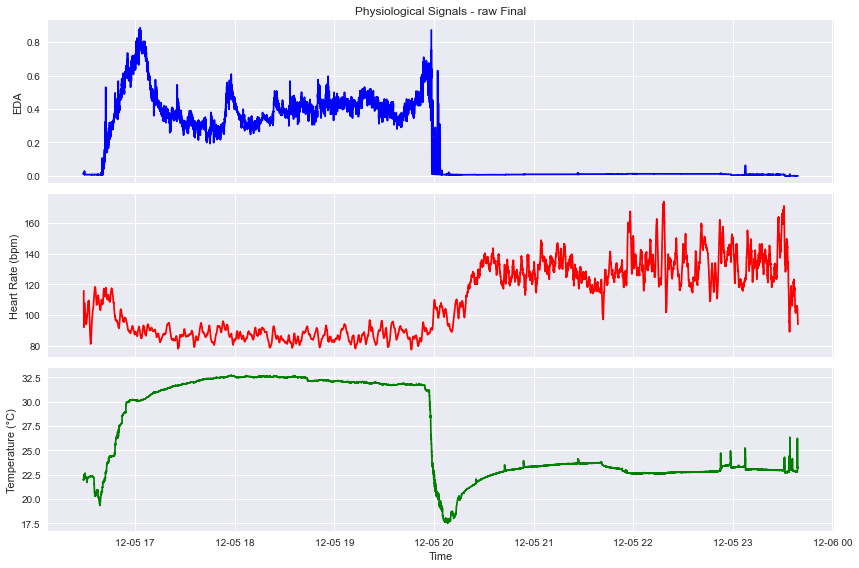

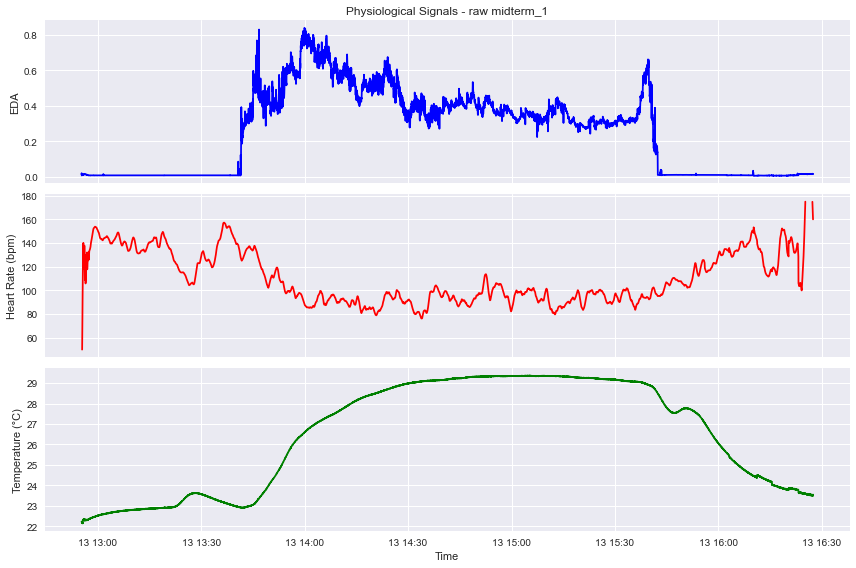

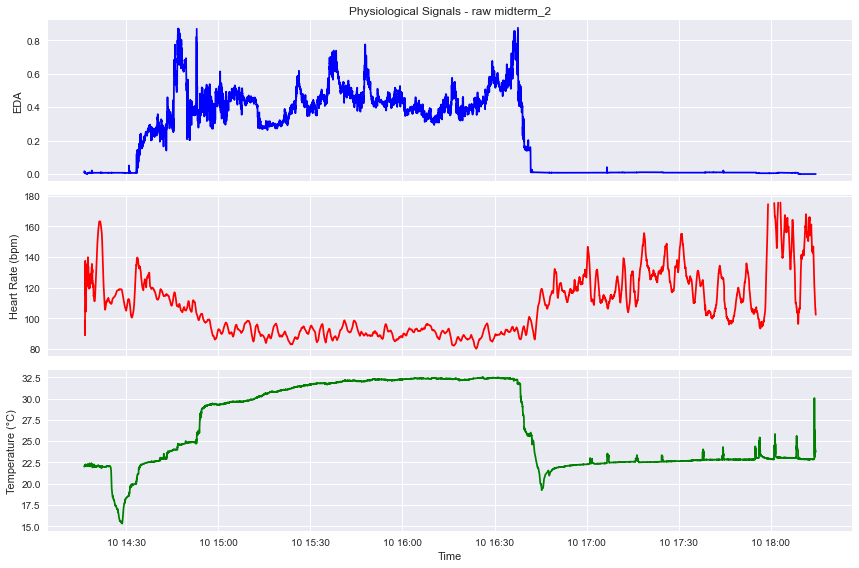

In [24]:
plot_all_subjects_sessions(preprocessed_df)